# Module 10 - Regression Algorithms - Ridge Regression with Standardized Inputs

With a standard linear regression, we had the issue of colinearity and model robustness when there are differences between the training and test set categories. By allowing new labels, we either introduce colinearity by not dropping off a category, or drop off a category and have new labels be encoded the same way.

It's okay for when irregularites in the dataset are rare, however, we have some better tools to work and help us!

**Side Note:** At a glance, many people may want to combine the two datasets (train/test) to get all categories, however, this is a bias that we'd rather not have in our models. By looking into the test/validation sets, you're essentially leaking information eariler than what should be known./

To get around this, we can introduce the Ridge regression, which allows us to work with colinear datasets and even ones where we have more predictors than rows!

A good article for the techie stuff is here: https://www.statisticshowto.com/ridge-regression/

In essence, we can use the ridge regression with all of our colinear variables due to the introduction of a L2 penalty, which shrinks all coefficients by the same factor.

One hard issue with a Ridge, however, is that we need to calculate this penalty term, K. However, there's some really useful CV methods for deriving this value automatically! I'll provide the first factor and then show how I derived it.

## Part A: Loading in Data

This is going to be exactly the same as the previous notebooks!

Load our packages:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Import our data and split X/Y:

In [24]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df = df.replace(np.nan, df.horsepower.mean())

df = df.drop("model", axis=1)

X = df.iloc[:,1:]
y = df.iloc[:,0]

Do our usualy train-test split:

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107)

And for consistency, we're going to show the same pairplots!

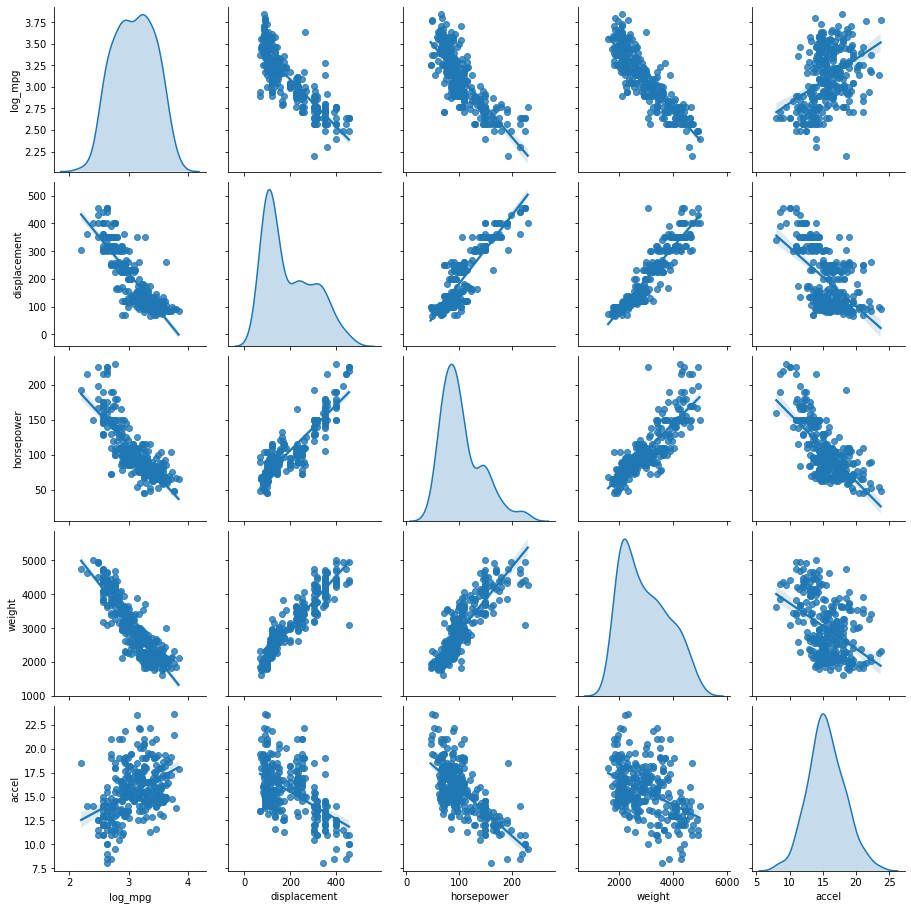

In [26]:
train_dataset = X_train.copy()
train_dataset.insert(0, "log_mpg", np.log(y_train))

sns.pairplot(train_dataset[['log_mpg','displacement','horsepower','weight','accel']], kind='reg', diag_kind='kde')

## Part B: Data Preprocessing and Pipeline

This is where the biggest change for our algorithm is going to be!

We need to:

- Standard Scale our continuous variables
- One hot encode (but not drop out) our categorical variables

This is all just minor tweaks to the models we looked at earlier!

We still define our numerical / categorical:

In [27]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

And we can build our transformer now:

- We one hot encode our catergorical, and now any unknowns are encoded as all zeros
- And we can standard scale our numerical columns, to help improve calculation efficiency (if not, may never converge)

It's not too much different!

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

And now we build our pipeline:

- I selected an alpha value for the penalty term, we'll cover how to get this later!

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=0.625),
        func = np.log,
        inverse_func = np.exp
    )
)

We still fit our model just the same!

In [30]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.625)))])

And we generate predictions the same way!

In [31]:
y_pred_in = model.predict(X_train)

## Part C: Evaluating Ridge Model

And now, let's look at our metrics for in sample performance:

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y_train, y_pred_in)
mean_squared_error(y_train, y_pred_in)
mean_absolute_error(y_train, y_pred_in)

0.8931199768423912

6.616290824474754

1.8440042442868598

Let's do our same plots for predictions and residuals:

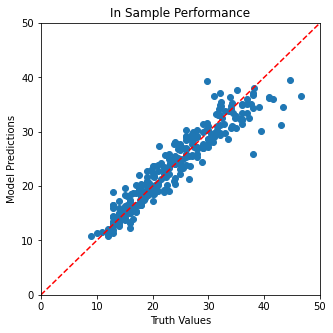

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, y_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

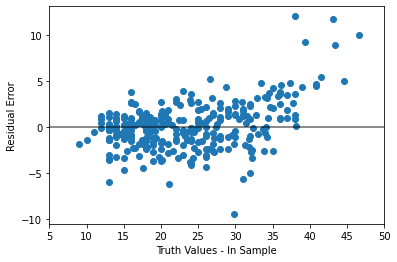

In [34]:
plt.scatter(y_train, y_train-y_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

It's looking good! Let's pull out our feature names and plot our coeffs!

In [35]:
feature_names = (model.named_steps['columntransformer']
                 .named_transformers_['onehotencoder']
                 .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([feature_names, numerical_columns])
feature_names

array(['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'cylinders_8', 'origin_1', 'origin_2', 'origin_3', 'year_70',
       'year_71', 'year_72', 'year_73', 'year_74', 'year_75', 'year_76',
       'year_77', 'year_78', 'year_79', 'year_80', 'year_81', 'year_82',
       'displacement', 'horsepower', 'weight', 'accel'], dtype=object)

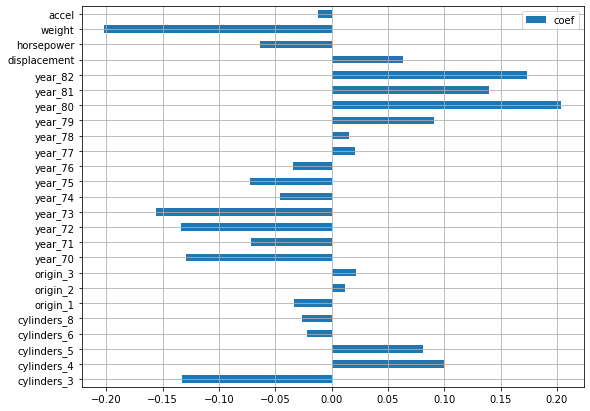

In [36]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['coef'], index=feature_names
)

coefs.plot(kind='barh', figsize=(9,7), grid=True)

Why do we no longer need to scale our coeffs by standard deviation?

Because the numerical columns were standardized by the preprocessor, which makes them all centered around zero with a std of 1!

Now, I'm sure you're wondering where I got the value for our penalty factor, which usually takes a long time to figure out. Turns out SKLearn has a cross validation feature for finding alpha sensitivity!

Within our training dataset, we're going to cross validate for the best alpha!

In [37]:
from sklearn.linear_model import RidgeCV

ridge_cv = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10,10,50)),
        func = np.log,
        inverse_func = np.exp
    )
)

ridge_cv.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_f...
       6.25055193e-01, 1.59985872e+00, 4.09491506e+00, 1.04811313e+01,
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1

And we can access the alpha for the best regressor:

In [38]:
ridge_cv[-1].regressor_.alpha_

0.6250551925273976

That's how I knew 0.625 was the correct penalty factor for our dataset!

Before we analyze our test sample, let's do our cross validation to gauge model stability:

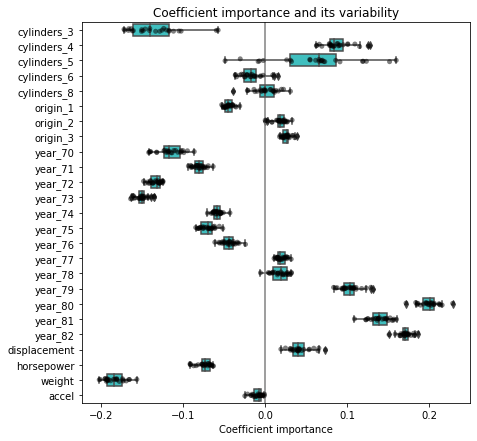

In [39]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

cv_coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ for est in cv_model['estimator']],
    columns=feature_names)

plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

Why does Ridge work so well?

We don't have to worry about unknown categorical features, and now there is much more smoothing between all the explanatory factors!

Weight is still the most important, however, there is much more weight on the rest of the factors!

This smoothing makes overfitting the test sample much less likely!

Let's now look at our testing set:

In [41]:
y_pred_out = model.predict(X_test)

Here's our metrics back in action:

In [42]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, y_pred_in), mean_squared_error(y_train, y_pred_in), mean_absolute_error(y_train, y_pred_in))
metrics['out'] = (r2_score(y_test, y_pred_out), mean_squared_error(y_test, y_pred_out), mean_absolute_error(y_test, y_pred_out))

metrics

,in,out
r2,0.893120,0.878901
mse,6.616291,7.013530
mae,1.844004,1.977962


Ridge has a slightly less out of sample $r^2$, however, we'll probably be more confident in the future predictive power due to less reliance on a single factor (weight). We're explaning a little less due to smoothing.

Let's get our plots back:

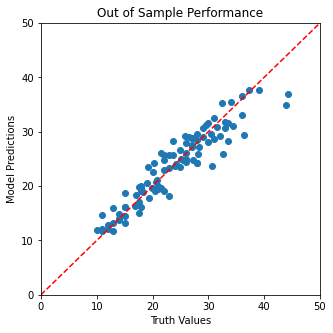

In [43]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_test, y_pred_out)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("Out of Sample Performance")
plt.show();

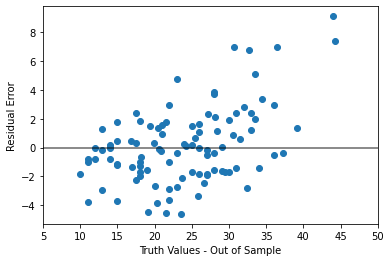

In [44]:
plt.scatter(y_test, y_test-y_pred_out)
plt.xlabel("Truth Values - Out of Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

And our last thing is the comparison between our three models and their cross validation performance:



**Linear Regression**

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/linear-regression-cv.png?raw=True width="400"/>
</div>

**Linear Regression with Transformed Target**

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/transformed-target-cv-variation.png?raw=True width="400"/>
</div>

**Ridge Regression**

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/ridge-cv.png?raw=True width="400"/>
</div>

There's some important things to note about our Ridge:

- The coefficients are much more balanced than before.
- We see a lot of variation in 3/5 cylinders, however, 3/5 cylinder cars are not that common
- The ranges of most other coefficients are now much more stable!

Why do we really like the Ridge regression?

- We can now introduce more explanatory variables without worrying about overfitting, as Ridge will penalize complexity and provide us with smoothing.

Where are we going next:

- We're going to add polynomial features to try to tease out the remaining non-linearity in the model!
- Ridge can handle the colinearity with polynomial features
- LASSO, to reduce complexity by sending some coefficients to zero!

Let's get into it!